In [ ]:
import numpy as np
from pickle import load
from votekit.utils import mentions
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt

# A nice function for showing matrix heatmaps
def show_matrix(M, title=None, labels = None, cmap='viridis'):
    fig, ax = plt.subplots()
    if title:
        plt.title(title)
    img = ax.imshow(M, cmap=cmap)
    fig.colorbar(img)
    if labels:
        ax.set_xticks(range(M.shape[0]))
        ax.set_xticklabels(labels)
        ax.set_yticks(range(M.shape[1]))
        ax.set_yticklabels(labels)
        ax.tick_params(axis='x', labelrotation=90)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_aspect('auto')
    plt.show()


Let's load a voter profile for analysis

In [207]:
with open('./data/Portland_D1.pkl', 'rb') as file:
    loaded = load(file)

In [208]:
loaded.keys()

dict_keys(['profile', 'boost', 'distance', 'comentions', 'candidates'])

In [209]:
boost = loaded['boost']
profile = loaded['profile']
candidates = loaded['candidates']
candidate_to_index = {candidate : i for i, candidate in enumerate(candidates)}
num_mentions = mentions(profile)
mentions_dict = mentions(profile)
all_cands_sorted_by_mentions = sorted(profile.candidates, reverse=True, key = lambda x: mentions_dict[x])

In [13]:
num_mentions = {key : value for key,value in num_mentions.items() if key in candidates}
num_mentions

{'Candace Avalos': 22332.0,
 'Cayle Tern': 9106.0,
 'Jamie Dunphy': 18561.0,
 'Loretta Smith': 18115.0,
 'Steph Routh': 20511.0,
 'Doug Clove': 7648.0,
 'Michael (Mike) Sands': 5233.0,
 'David Linn': 9358.0,
 'Timur Ender': 16918.0,
 'Deian Salazar': 5284.0,
 'Peggy Sue Owens': 3908.0,
 'Joe Allen': 4985.0,
 'Joe Furi': 4095.0,
 'Terrence Hayes': 16089.0,
 'Noah Ernst': 11696.0,
 'Thomas Shervey': 3543.0}

In [14]:
total_mentions = sum(num_mentions.values())
share_mentions = {key : value/total_mentions for key,value in num_mentions.items()}

del num_mentions

share_mentions

{'Candace Avalos': 0.1258977799325749,
 'Cayle Tern': 0.051335535736433235,
 'Jamie Dunphy': 0.10463857663122526,
 'Loretta Smith': 0.10212422906495586,
 'Steph Routh': 0.11563180029540765,
 'Doug Clove': 0.04311598696598302,
 'Michael (Mike) Sands': 0.029501302274187912,
 'David Linn': 0.05275619848688142,
 'Timur Ender': 0.09537608100032698,
 'Deian Salazar': 0.029788817354635757,
 'Peggy Sue Owens': 0.022031547733140904,
 'Joe Allen': 0.02810318972612779,
 'Joe Furi': 0.02308576969478301,
 'Terrence Hayes': 0.0907025515554002,
 'Noah Ernst': 0.06593679178270626,
 'Thomas Shervey': 0.019973841765229844}

In [15]:
sum(share_mentions.values())

1.0

Alternatively, we can use votekit's csv loader mathod

In [217]:
from votekit.cvr_loaders import load_csv

profile = load_csv("Portland_D1_raw_votekit_format.csv", rank_cols=[1,2,3,4,5,6])

In [218]:
from votekit.cleaning import remove_and_condense

num_ballots_cast = profile.total_ballot_wt

num_overvotes_first_place = sum(b.weight for b in profile.ballots if b.ranking[0] == {"overvote"})
num_ballots_with_overvotes = sum(b.weight for b in profile.ballots if any(cand_set == {"overvote"} for cand_set in b.ranking))

profile = remove_and_condense("overvote", profile)

num_ballots_spoiled_by_ov_skips = num_ballots_cast - profile.total_ballot_wt 
print(f"{num_ballots_spoiled_by_ov_skips} ballots, or {num_ballots_spoiled_by_ov_skips/num_ballots_cast:.1%} of all ballots, were spoiled by overvotes or skips in D1.")

# remove UWI's here
profile = remove_and_condense(['Write-in-120', 'Write-in-121', 'Write-in-122'], profile)

num_ballots_scrubbed_by_wi = num_ballots_cast - num_ballots_spoiled_by_ov_skips-profile.total_ballot_wt 
print(f"{num_ballots_scrubbed_by_wi} ballots, or {num_ballots_scrubbed_by_wi/num_ballots_cast:.1%} of all ballots, were scrubbed by write ins in D1.")

712.0 ballots, or 1.6% of all ballots, were spoiled by overvotes or skips in D1.
86.0 ballots, or 0.2% of all ballots, were scrubbed by write ins in D1.


In [219]:
from votekit.cleaning import remove_repeated_candidates, condense_profile

profile = condense_profile(remove_repeated_candidates(profile))

In [65]:
profile

Profile has been cleaned
Profile contains rankings: True
Maximum ranking length: 6
Profile contains scores: False
Candidates: ('Thomas Shervey', 'Cayle Tern', 'Noah Ernst', 'Joe Furi', 'Candace Avalos', 'David Linn', 'Doug Clove', 'Michael (Mike) Sands', 'Jamie Dunphy', 'Joe Allen', 'Loretta Smith', 'Peggy Sue Owens', 'Steph Routh', 'Uncertified Write In', 'Deian Salazar', 'Timur Ender', 'Terrence Hayes')
Candidates who received votes: ('Candace Avalos', 'Cayle Tern', 'Jamie Dunphy', 'Loretta Smith', 'Steph Routh', 'Doug Clove', 'Michael (Mike) Sands', 'David Linn', 'Timur Ender', 'Deian Salazar', 'Peggy Sue Owens', 'Joe Allen', 'Joe Furi', 'Terrence Hayes', 'Noah Ernst', 'Thomas Shervey', 'Uncertified Write In')
Total number of Ballot objects: 19872
Total weight of Ballot objects: 42871.0

Let's cook up some ways to evaluate partitions of candidates.

First, the cut score of a partition. That is, we construct the matrix $M$ such that $M_{ij}$ is the number of times candidate $i$ appeared next to candidate $j$ on a ballot. The cut score of a partition $P$ of the candidates is
$$
\sum_{S,S'\in P, S\neq S'} \sum_{x\in S, y\in S'} M_{xy}.
$$


In [16]:
adjacencies = np.zeros((len(candidates), len(candidates)))

for ballot in tqdm(profile.ballots):
    ranking = []
    for set in ballot.ranking:
        if len(set) == 1:
            name, = set
            if name in ranking:
                continue #Repeated name in this one. Throw it out.
            if name in candidates:
                ranking.append(name) #Ignore names that aren't in the candidate list
    
    if len(ranking) <= 1:
        continue
    
    for i in range(len(ranking) - 1):
        adjacencies[candidate_to_index[ranking[i]],
                    candidate_to_index[ranking[i-1]]
                    ] += ballot.weight
        
adjacencies = adjacencies + adjacencies.T

100%|██████████| 19933/19933 [00:00<00:00, 199062.99it/s]


In [ ]:
from votekit.matrices import matrix_heatmap, boost_matrix, candidate_distance_matrix, comentions_matrix
fig, ax = plt.subplots(figsize=(12,12))

ax  = matrix_heatmap(adjacencies, row_labels=cand, 
                        column_labels=all_last_names,
                        row_label_rotation = 0,
                        column_label_rotation = 90,
                        ax = ax,
                        cell_font_size = 12)

KeyboardInterrupt: 

In [220]:
all_cands_sorted_by_mentions = sorted(profile.candidates, reverse=True, key = lambda x: mentions_dict[x])

In [221]:
all_cands_sorted_by_mentions.remove("Uncertified Write In")

In [222]:
# computes the matrix
bm  = boost_matrix(profile, candidates = all_cands_sorted_by_mentions)

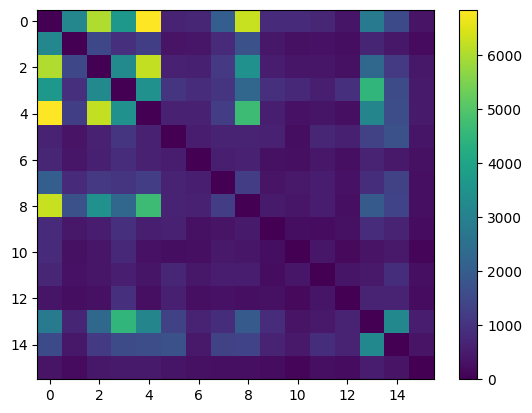

In [18]:
show_matrix(adjacencies)

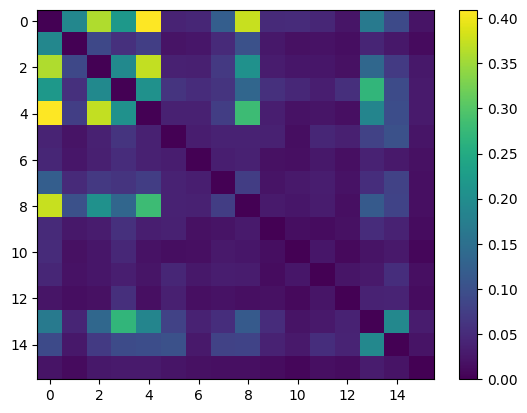

np.float64(0.062499999999999986)

In [19]:
adjacencies /= (adjacencies.mean() * len(candidates))

show_matrix(adjacencies)
adjacencies.mean()

In [21]:
# Ready to define the cut score
def cut_score(partitions):
    sum = 0
    for part1 in partitions:
        for part2 in partitions:
            if part1 == part2:
                continue
            for c1 in part1:
                for c2 in part2:
                    sum += adjacencies[
                        candidate_to_index[c1],
                        candidate_to_index[c2]
                        ]
    return sum

Another metric by which to judge partitions: relative sizes. A partition with very different sizes would be a poor partition. Given a partition $P$ of candidates, define the Achlioptas score to be
$$
\prod_{S\in P} \mathrm{mentions}(S)
$$
where $\mathrm{mentions}(S)$ is the sum of all the mentions of the candidates in the set $S$.

This score is maximized when all the partitions have the same number of mentions. If we'd rather be minimizing, we can instead use the inverse
$$
\prod_{S\in P} \frac{1}{\mathrm{mentions}(S)}.
$$

In [22]:
def relative_size_score(partitions):
    sizes = []
    for part in partitions:
        sizes.append(
            sum([share_mentions[candidate] for candidate in part])
        )
    score = 1
    for size in sizes:
        score *= size
    return 1/score

We could also look specifically at the first and second place votes in each ballot.

[FILL IN HERE]

In [363]:
from votekit.pref_profile import PreferenceProfile
# returns an n x n matrix where (i, j) is the row-normalized weight of ballots 
# where a candidate from block j was ranked 1st and a candidate from block i was ranked 2nd
# each block is a list of candidate names, and blocks is a list of these blocks.
def blockiness_mtx(profile: PreferenceProfile, partition):
    num_blocks = len(partition)
    block_lists = [set(block) for block in partition]
    blockiness = np.zeros((num_blocks, num_blocks))

    for ballot in profile.ballots:
        # get first ranked candidate and their block    
        first_rank = ballot.ranking[0]
        first_cand = list(first_rank)[0]
        first_block = None
        for i, block in enumerate(block_lists):
            if first_cand in block:
                first_block = i
                break
        # if bullet ballot then count it as if second vote was also in that block
        # TODO is this the "right" approach?
        if len(ballot.ranking) == 1:
            blockiness[first_block, first_block] += float(ballot.weight)
            continue

        # get secon ranked candidate and their block
        second_rank = ballot.ranking[1]
        second_cand = list(second_rank)[0]
        second_block = None
        for i, block in enumerate(block_lists):
            if second_cand in block:
                second_block = i
                break
                   
        blockiness[second_block, first_block] += float(ballot.weight)

    row_sums = blockiness.sum(axis=1)
    normed_blockiness = np.zeros_like(blockiness)

    for i in range(len(blockiness)):
        if row_sums[i] != 0:
            normed_blockiness[i] = blockiness[i] / row_sums[i]

    return normed_blockiness


In [339]:
def propose_swap(order, get_score):
    n = len(order)
    i, j = np.random.choice(n, 2, replace=False)
    candidate_order = order.copy()
    candidate_order[i], candidate_order[j] = candidate_order[j], candidate_order[i]
    candidate_score = get_score(candidate_order)
    return candidate_order, candidate_score


In [358]:
def mc_blockiness_fixed_block_size(profile, all_cands, steps):
    n = len(all_cands)
    order = np.arange(n)
    k = n // 3  # size of each block

    trace_scores = []
    # track best scores
    best_scores = []

    def get_score(order):
        permuted = [all_cands[i] for i in order]
        block1, block2, block3 = permuted[:k], permuted[k:2*k], permuted[2*k:]
        M= blockiness_mtx(profile, [block1, block2, block3])
        return np.trace(M)  
        #M = blockiness_mtx_3votes(profile, block1, block2, block3)
        #return np.sum(M)      

    current_score = get_score(order)

    for step in range(steps):
        proposed_order, proposed_score, = propose_swap(order,get_score)

        # accept with probability min(1, e^(new - old)) 
        f = proposed_score - current_score
        accept = False
        if f < 0:
            accept = True
        elif np.random.rand() < np.exp(f):
            accept = True

        if accept:
            order = proposed_order
            current_score = proposed_score

        # keep track of best scores
        if len(best_scores) < 10:
            best_scores.append((current_score, order.copy(), step))
            best_scores.sort(key=lambda x: x[0])
        elif current_score > best_scores[-1][0]:
            best_scores[-1] = (current_score, order.copy(), step)
            best_scores.sort(key=lambda x: x[0])

        trace_scores.append(current_score)

    return best_scores, trace_scores

In [359]:
best_order, trace_scores = mc_blockiness_fixed_block_size(profile, all_cands_sorted_by_mentions, 100)

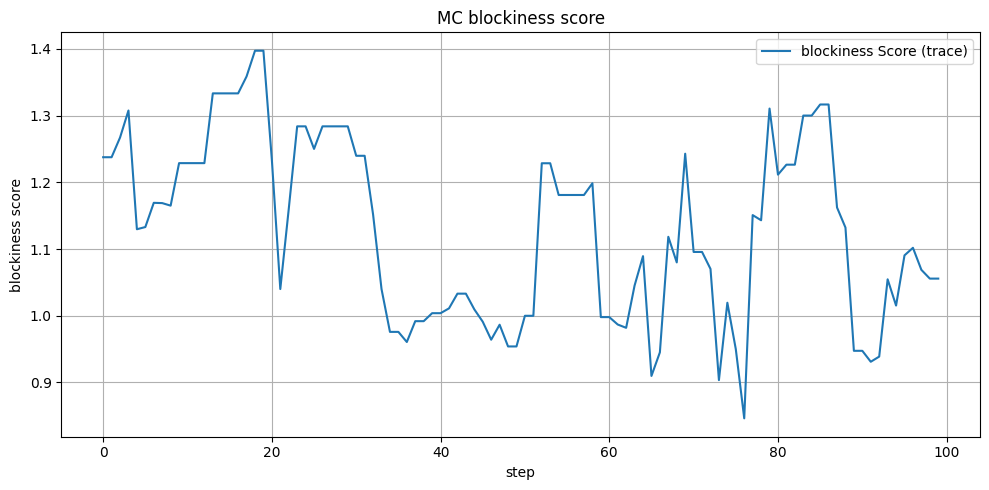

In [361]:
plt.figure(figsize=(10, 5))
plt.plot(trace_scores, label="blockiness Score (trace)")
plt.xlabel("step")
plt.ylabel("blockiness score")
plt.title("MC blockiness score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [252]:
best_order[9][1]

array([10,  4, 15,  2,  7,  5, 11,  0, 12,  8,  3,  9,  1, 14,  6, 13])

In [238]:
all_last_names

['Avalos',
 'Routh',
 'Dunphy',
 'Smith',
 'Ender',
 'Hayes',
 'Ernst',
 'Linn',
 'Tern',
 'Clove',
 'Salazar',
 'Sands',
 'Allen',
 'Furi',
 'Owens',
 'Shervey']

<Axes: >

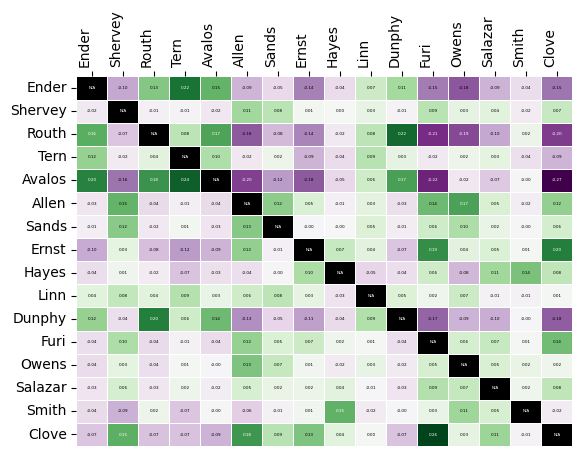

In [352]:
labels_reordered = [all_last_names[i] for i in best_order[9][1]]
bm_reordered = bm[np.ix_(best_order[9][1], best_order[9][1])]
# Plot the reordered matrix
matrix_heatmap(bm_reordered, row_labels=labels_reordered,
               column_labels=labels_reordered,
               row_label_rotation=0, column_label_rotation=90)

<Axes: >

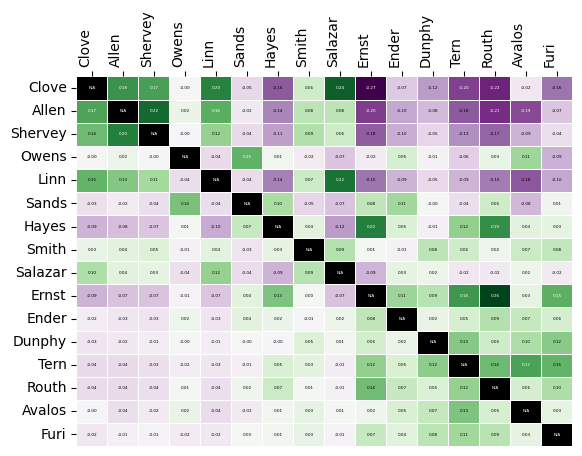

In [184]:
# plot the best score
labels_reordered = [all_last_names[i] for i in best_order[9][1]]
bm_reordered = bm[np.ix_(best_order[9][1], best_order[9][1])]
matrix_heatmap(bm, row_labels=labels_reordered,
               column_labels=labels_reordered,
               row_label_rotation=0, column_label_rotation=90)

Given metrics we want to minimize, we can use a Markov chain to find partitions that minimize them. Let's spin up a simple Markov chain.

In [362]:
# We'll need a random starting place for our Markov chain.
def random_partition(lst, k):
    shuffled = lst[:]
    random.shuffle(shuffled)
    partition = [[] for _ in range(k)]
    for idx, item in enumerate(shuffled):
        partition[idx % k].append(item)
    return partition

k = 2 # Number of slates we want to find
partition = random_partition(candidates, k)
partition

[['Joe Allen',
  'Peggy Sue Owens',
  'Jamie Dunphy',
  'Candace Avalos',
  'Noah Ernst',
  'Thomas Shervey',
  'Terrence Hayes',
  'Steph Routh'],
 ['Timur Ender',
  'Joe Furi',
  'Deian Salazar',
  'David Linn',
  'Michael (Mike) Sands',
  'Loretta Smith',
  'Cayle Tern',
  'Doug Clove']]

In [367]:
# The heart of the Markov chain. Given a partition of the candidates, propose a new partition.
def proposal(partition, candidates):
    partition = [part.copy() for part in partition]
    random_candidate = candidates[random.randint(0,len(candidates)-1)]
    random_partition = random.randint(0,len(partition)-1)
    #Remove the random candidate from their partition
    for part in partition:
        if random_candidate in part:
            if len(part) == 1: #If this is the last candidate, don't remove them
                return partition
            part.remove(random_candidate)
    partition[random_partition].append(random_candidate)
    return partition

# The objective we want to minimize
def total_score(partition):
    alpha, beta = 10, 5 #Change these to balance the objectives!
    return alpha * cut_score(partition) + beta * relative_size_score(partition) - np.trace(blockiness_mtx(profile, partition))


In [188]:
# Here's the random partition we're starting with.
partition

[['Timur Ender',
  'Deian Salazar',
  'Cayle Tern',
  'David Linn',
  'Terrence Hayes',
  'Peggy Sue Owens',
  'Jamie Dunphy',
  'Candace Avalos'],
 ['Joe Allen',
  'Loretta Smith',
  'Noah Ernst',
  'Doug Clove',
  'Steph Routh',
  'Thomas Shervey',
  'Joe Furi',
  'Michael (Mike) Sands']]

In [368]:
# Run the Markov chain
num_steps = 200
cur_score = total_score(partition)
best_score = cur_score
best_partition = [part.copy() for part in partition]

for _ in range(num_steps):
    new_partition = proposal(partition, candidates)
    new_score = total_score(new_partition)
    cutoff = np.exp(cur_score - new_score)
    if np.random.random() < cutoff:
        partition = new_partition
        cur_score = new_score
        if cur_score < best_score:
            best_score = cur_score
            best_partition = [part.copy() for part in partition]
            print("New best!")

New best!
New best!
New best!
New best!
New best!
New best!
New best!
New best!
New best!
New best!
New best!
New best!
New best!
New best!


In [369]:
print("Best total score:", best_score)
print("Cut score:", cut_score(best_partition))
print("Achlioptas score:", relative_size_score(best_partition))
print("Blockiness score:", np.trace(blockiness_mtx(profile, best_partition)))

print("Best partition:")
display(best_partition)


Best total score: 74.66666271856077
Cut score: 4.156260513940082
Achlioptas score: 6.878139683955691
Blockiness score: 1.2866408406185226
Best partition:


[['Loretta Smith',
  'Steph Routh',
  'Terrence Hayes',
  'Noah Ernst',
  'Timur Ender',
  'Deian Salazar',
  'Cayle Tern',
  'Jamie Dunphy',
  'Candace Avalos',
  'Thomas Shervey',
  'Peggy Sue Owens'],
 ['Joe Furi', 'Michael (Mike) Sands', 'Doug Clove', 'David Linn', 'Joe Allen']]

In [370]:
# Sort each slate of candidates by mentions
for part in best_partition:
    part.sort(key=(lambda x: share_mentions[x]), reverse=True)
best_partition

[['Candace Avalos',
  'Steph Routh',
  'Jamie Dunphy',
  'Loretta Smith',
  'Timur Ender',
  'Terrence Hayes',
  'Noah Ernst',
  'Cayle Tern',
  'Deian Salazar',
  'Peggy Sue Owens',
  'Thomas Shervey'],
 ['David Linn', 'Doug Clove', 'Michael (Mike) Sands', 'Joe Allen', 'Joe Furi']]

In [371]:
#Combine into one order!
candidate_order = []
for part in best_partition:
    candidate_order += part

candidate_order

['Candace Avalos',
 'Steph Routh',
 'Jamie Dunphy',
 'Loretta Smith',
 'Timur Ender',
 'Terrence Hayes',
 'Noah Ernst',
 'Cayle Tern',
 'Deian Salazar',
 'Peggy Sue Owens',
 'Thomas Shervey',
 'David Linn',
 'Doug Clove',
 'Michael (Mike) Sands',
 'Joe Allen',
 'Joe Furi']

In [372]:
# Let's permute the boost matrix and see how it looks
permutation_list = []
for candidate in candidates:
    permutation_list.append(
        candidate_order.index(candidate)
    )

permutation_matrix = np.zeros((len(candidates),len(candidates)))
for i, p in enumerate(permutation_list):
    permutation_matrix[i,p] = 1

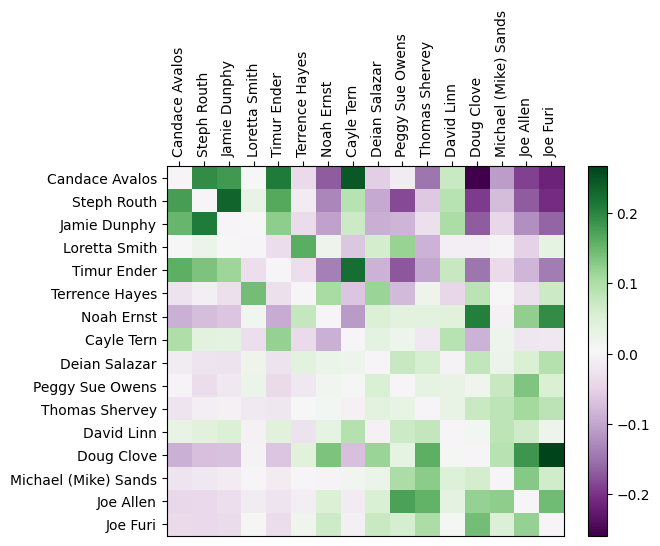

In [373]:
# Let's permute the boost matrix and see how it looks
permutation_list = []
for candidate in candidates:
    permutation_list.append(
        candidate_order.index(candidate)
    )

permutation_matrix = np.zeros((len(candidates),len(candidates)))
for i, p in enumerate(permutation_list):
    permutation_matrix[i,p] = 1

show_matrix(permutation_matrix.T @ boost @ permutation_matrix, labels = candidate_order, cmap='PRGn')

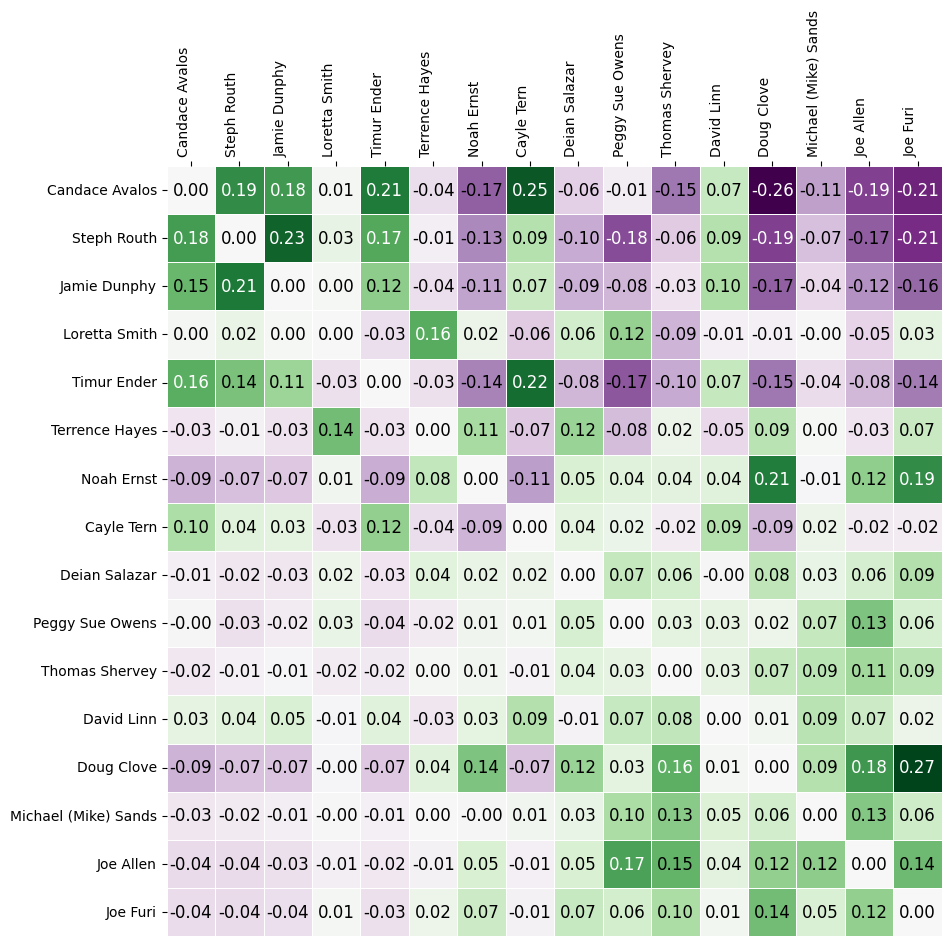

In [374]:
from votekit.matrices import matrix_heatmap, boost_matrix, candidate_distance_matrix, comentions_matrix

fig, ax = plt.subplots(figsize=(10,10))

ax  = matrix_heatmap(permutation_matrix.T @ boost @ permutation_matrix, row_labels=candidate_order, 
                        column_labels=candidate_order,
                        row_label_rotation = 0,
                        column_label_rotation = 90,
                        ax = ax,
                        cell_font_size = 12)